In [470]:
# This is to test the inheritance of functions in python. 
# If a function F of same name exists in class B and class A where B inherits from A, 
# then for instance of B function from F from B will be used. 

# class A:
    
#     def __init__(self,a):
        
#         self.a = a
#         return None 
    
#     def check(self):
#         print("Helloe")
#         return None 
    
#     def newPrint(self):
        
#         print('This is from class A:  ',self.a)
#         return None
    
    
# class B(A):
    
#     def __init__(self,b):
        
#         self.b = b
#         return None
    
#     def newPrint(self):
#         print('This is from class B', self.b)
#         return None 

In [1]:
from tqdm import tqdm 
from networkx.algorithms import bipartite
from scipy.stats import binned_statistic as bin1d
import numpy as np 
import networkx as nx 
import pandas as pd 
import matplotlib.pyplot as plt 
import json 
import itertools
import random
%matplotlib inline 


def plot_dd(List,label):
        
        fig = plt.figure(figsize=(4,4))
        ax = fig.add_subplot(111)
        
        if min(List) != 0 :
            
            bins = np.logspace(np.log10(min(List)),np.log10(max(List)),50)
        else:
            bins = np.logspace(np.log10(1),np.log10(max(List)),50)
        
        pk,k,_ = bin1d(List,List,statistic='count',bins=bins)
        
        N = k[1:] - k[:-1]
        
        x,y = k[1:],pk/(sum(pk)*N)
        
        ax.loglog(x,y,'--',color='darkred')
#         ax.hist(degrees,bins=bins,density=True)
        ax.set_xlabel('k',fontsize=14)
        ax.set_ylabel('P(k)',fontsize=14)
#         ax.set_xscale('log')
#         ax.set_yscale('log')
        ax.set_title(f'{label} Degree Distribution')
    
        fig.tight_layout()
        plt.show()
        return None 

In [2]:
#### Defining class for the network growth model

class ramasco_model:
    
    
    def __init__(self,m,n,n_steps,n_top=0,n_btm=0,init_edges:int=0,init=False):
        
        self.m = m ## number of new actors 
        self.n = n ## total actors added for a every new movie
        self.initialize = init
        if self.n < self.m:
            raise ValueError('n should be larger than m')
        
        self.totalTime = n_steps ## Time Steps for evolution
        self.topNodes = []
        self.btmNodes = []
        self.edges = []
        self.n_edges = np.zeros(self.totalTime)
        
        if self.initialize:
            
            self.init_topNodes = range(n_top)
            self.init_btmNodes = range(n_steps,n_steps+n_btm)
            
            if not init_edges <= self.n*self.m:
                raise ValueError('# of initial edges cannot be more than the product of n*m in unweighted graph')
            
            
            self.topNodes = self.init_topNodes
            self.btmNodes = self.init_btmNodes
            self.edges = random.sample(set(itertools.product(self.init_topNodes,self.init_btmNodes)),init_edges)
        
        return None
    
    def create_Graph(self):
        
        G = nx.Graph()
        G.add_nodes_from(self.topNodes,bipartite=0)
        G.add_nodes_from(self.btmNodes,bipartite=1)
        G.add_edges_from(self.edges)
        return G
    
    def simulate(self):
        
        G = self.create_Graph()
        
        if not self.initialize:
            
            self.topNodes.append(0)
            self.btmNodes.extend(list(range(self.totalTime,self.totalTime+self.n)))
            self.edges.extend(list(zip([0]*self.n,self.btmNodes)))
            
            self.n_edges[0] = len(self.edges)
            potential_old_targets = self.btmNodes
            
            for t in range(1,self.totalTime):
        
                new_btmNodes = list(range(max(self.btmNodes)+1,max(self.btmNodes)+1+self.m))
                new_topNode = t
                
                newActors_edges = list(zip([new_topNode]*self.m,new_btmNodes))
                
                if self.n-self.m > len(potential_old_targets):
                    old_actors = random.sample(potential_old_targets,len(potential_old_targets))
                else:
                    old_actors = random.sample(potential_old_targets,self.n-self.m)
                
                oldActors_edges = list(zip([new_topNode]*len(old_actors),old_actors))
                
                potential_old_targets.extend(old_actors)
                potential_old_targets.extend(new_btmNodes)
                
                self.edges.extend(newActors_edges)
                self.edges.extend(oldActors_edges)
                self.topNodes.append(new_topNode)
                self.btmNodes.extend(new_btmNodes)
                
                self.n_edges[t] = len(self.edges)
            
            G.add_nodes_from(self.topNodes,bipartite=0)
            G.add_nodes_from(self.btmNodes,bipartite=1)
            G.add_edges_from(self.edges)
            
            return G
        
        else:
            print('Not programmed yet')
            return None
            
    
    def plot_dd(self,Graph,set_indx,label,axes=False):
        
        if type(axes) == bool:
        
            fig = plt.figure(figsize=(4,4))
            ax = fig.add_subplot(111)
        
        else:
            ax = axes
        
        if type(set_indx) == int:
        
            nodeSet = [i for i,j in Graph.nodes(data=True) if j['bipartite']==set_indx]
            degrees = [Graph.degree(i) for i in nodeSet]
        
        else:
            
            degrees = list(dict(Graph.degree()).values())
        
        degrees.sort()
        x,y = np.unique(degrees,return_counts=True)
        
        if min(degrees) != 0 :
            
            bins = np.logspace(np.log10(min(degrees)),np.log10(max(degrees)),20)
        else:
            bins = np.logspace(np.log10(1),np.log10(max(degrees)),20)
        
        pk,k,_ = bin1d(degrees,degrees,statistic='count',bins=bins)
        
        
        N = k[1:] - k[:-1]
        
        x,y = k[1:],pk/(sum(pk)*N)

#         y = y/sum(y)
        
        ax.plot(x,y,'o',color='darkred')
#         ax.hist(degrees,bins=bins,density=True)
        ax.set_xlabel('k',fontsize=14)
        ax.set_ylabel('P(k)',fontsize=14)
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.set_title(f'{label} Degree Distribution')
        
        return None
    
    
    def plot_degcorr(self,Graph,label,axes=False):
        
        if type(axes) == bool:
        
            fig = plt.figure(figsize=(4,4))
            ax = fig.add_subplot(111)
        
        else:
            ax = axes
        
        x,y = [],[]
        
        
        for (i,j) in Graph.edges():
            
            x.append(Graph.degree(i))
            y.append(Graph.degree(j))
        
        k_nn,bins,_, = bin1d(x,y,statistic='mean',bins=30) 
        
        ax.loglog(bins[1:],k_nn,'--.',color='darkred')
        ax.set_xlabel('k',fontsize=14)
        ax.set_ylabel(r'$k_{nn}(k)$',fontsize=18)
        ax.set_title('Near Nbr Degree dist.')

        return None

## To Consider 

* make sure that the init_edges is a number 
* adding of edges should be different node types. Here we have no way to distinguish that in the edges description. therefore we start the bottom edges from the T parameter since that is the maximum number of top nodes there ever will be in the model

In [3]:
G1 = ramasco_model(1,3,1000,n_top=2,n_btm=3,init_edges=2,init=False)

In [4]:
G = G1.simulate()

In [5]:
topNodes = [n for n,j in G.nodes(data=True) if j['bipartite']==0]
btmNodes = [n for n,j in G.nodes(data=True) if j['bipartite']==1]

In [6]:
btm_projection = bipartite.projected_graph(G,btmNodes)

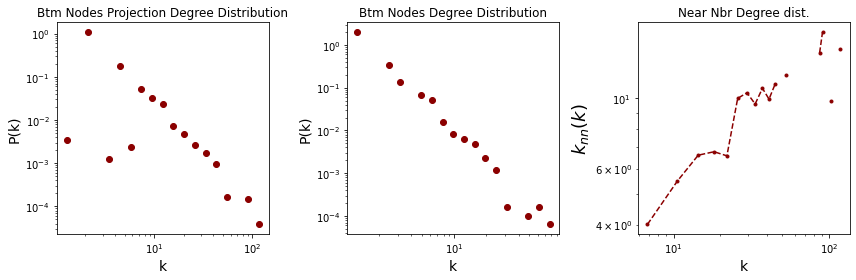

In [7]:
fig,ax = plt.subplots(figsize=(12,4),ncols=3,sharex=False,sharey=False)

G1.plot_dd(btm_projection,False,'Btm Nodes Projection',axes=ax[0])
G1.plot_dd(G,1,'Btm Nodes',axes=ax[1])
G1.plot_degcorr(btm_projection,'',axes=ax[2])
fig.tight_layout()

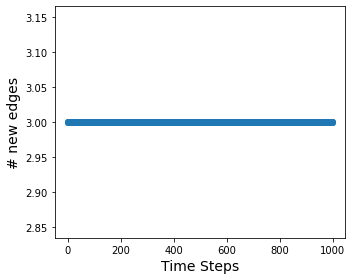

In [8]:
plt.figure(figsize=(5,4))
plt.plot(range(1,G1.totalTime),G1.n_edges[1:]-G1.n_edges[:-1],'-o')
plt.xlabel('Time Steps',fontdict={'size':14})
plt.ylabel('# new edges',fontdict={'size':14})
plt.tight_layout()

In [9]:
# help(np.random.choice)

In [10]:
class user_object_model(ramasco_model):
    
    
    def __init__(self,w,m,n,n_steps,gamma_e,gamma_i,init=False):
        
        self.w = w
        self.m = m
        self.n = n
        
#         if (self.w < self.m) or (self.w < self.n):
            
#             raise ValueError('w should be greater than m and n') # here we assume that user's attention is finite 
        
        self.gamma_e = gamma_e
        self.gamma_i = gamma_i
        self.totalTime = n_steps
        
        self.topNodes = []   ### users
        self.btmNodes = []   ### objects
        self.edges = []
        self.initialize = init
        self.n_edges = np.zeros(self.totalTime)
        
        return None
    
    def get_prob(self,nodeList,gamma):
        
        '''
        this gives the probability for selection of every node based on the attachment kernel. 
                    A(k) = (k+gamma)/sum(k+gamma)
                    
        Note that if gamma --> infty then it is a purely random attachment whereas when gamma --> 0 it
        is purely preferential attachment 
        
        '''
        
        x,px = np.unique(nodeList,return_counts=True)
        px = (px+gamma)/np.sum(px+gamma)
        
        return x,px
    
    
    def simulate(self):
        
        G = self.create_Graph()
        
        if not self.initialize:
            
            self.topNodes.append(0)
            self.btmNodes.extend(list(range(self.totalTime,self.totalTime+self.w)))
            
            selected_targets = []
            
            potential_targets = selected_targets + self.btmNodes
            
            if self.w < self.m: ### if number of new objects is less than new edges by a user we set m=w
                
                self.edges.extend(list(zip([0]*self.w),potential_targets))
                selected_targets.extend(self.btmNodes)
            else:
                
                NewUsr_targets = np.random.choice(potential_targets,self.m,replace=False)
                
                self.edges.extend(list(zip([0]*self.m,NewUsr_targets)))
                
                selected_targets.extend(NewUsr_targets)
            
            self.n_edges[0] = len(self.edges)
            
            for t in tqdm(range(1,self.totalTime)):
                
                self.topNodes.append(t)
                new_btmNodes = list(range(max(self.btmNodes)+1,max(self.btmNodes)+1+self.w))
                self.btmNodes.extend(new_btmNodes)
                
                potential_targets = selected_targets + self.btmNodes
                
                if (len(self.btmNodes) < self.m) or (len(self.btmNodes) < self.n): 
                    ### Change this for new edges and old edges
                    self.edges.extend(list(zip([t]*self.m),self.btmNodes))
                
                else:
                    
                    potential_NewUsr_targets,prob_e = self.get_prob(potential_targets,self.gamma_e)
                    
                    NewUsr_targets = np.random.choice(potential_NewUsr_targets,self.m,replace=False,p=prob_e)
                    
                    potential_OldUsr_targets,prob_i = self.get_prob(potential_targets,self.gamma_i)
                    
                    OldUsr_targets = np.random.choice(potential_OldUsr_targets,self.n,replace=False,p=prob_i)
                    
                    randomOldusr = np.random.choice(self.topNodes[:-1],self.n)
                    
                    self.edges.extend(list(zip(randomOldusr,OldUsr_targets)))
                    self.edges.extend(list(zip([t]*self.m,NewUsr_targets)))
                    
                    selected_targets.extend(NewUsr_targets)
                    selected_targets.extend(OldUsr_targets)
                
                    
                self.n_edges[t] = len(self.edges)
            
            G.add_nodes_from(self.topNodes,bipartite=0)
            G.add_nodes_from(self.btmNodes,bipartite=1)
            G.add_edges_from(self.edges)
            
            return G
        else:
            print("not programmed yet")
            return None 

In [11]:
Gu = user_object_model(5,3,2,1000,2,2)

In [12]:
G2 = Gu.simulate()

100%|██████████| 999/999 [00:01<00:00, 626.59it/s] 


In [13]:
topNodes = [n for n,j in G2.nodes(data=True) if j['bipartite']==0]
btmNodes = [n for n,j in G2.nodes(data=True) if j['bipartite']==1]

In [14]:
btm_projection = bipartite.projected_graph(G2,btmNodes)

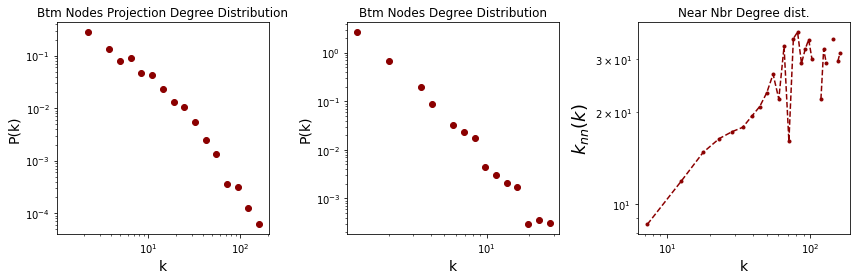

In [15]:
fig,ax = plt.subplots(figsize=(12,4),ncols=3,sharex=False,sharey=False)

Gu.plot_dd(btm_projection,False,'Btm Nodes Projection',axes=ax[0])
Gu.plot_dd(G2,1,'Btm Nodes',axes=ax[1])
Gu.plot_degcorr(btm_projection,'',axes=ax[2])
fig.tight_layout()

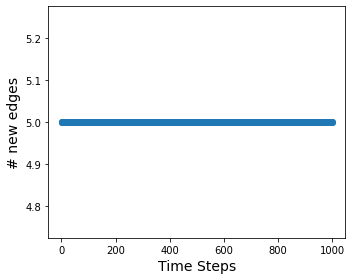

In [16]:
plt.figure(figsize=(5,4))
plt.plot(range(1,Gu.totalTime),Gu.n_edges[1:]-Gu.n_edges[:-1],'-o')
plt.xlabel('Time Steps',fontdict={'size':14})
plt.ylabel('# new edges',fontdict={'size':14})
plt.tight_layout()

In [17]:
## creating a function running n simulations and reporting average degree distribution 

In [18]:
from time import sleep
from tqdm import trange, tqdm
from multiprocessing import Pool, RLock, freeze_support

In [19]:
help(Pool)

Help on method Pool in module multiprocessing.context:

Pool(processes=None, initializer=None, initargs=(), maxtasksperchild=None) method of multiprocessing.context.DefaultContext instance
    Returns a process pool object



In [20]:
def multi_sim(i):
    
    G = ramasco_model(1,3,1000,n_top=2,n_btm=3,init_edges=2,init=False)
    G1 = G.simulate()
    
    btmNodes = [n for n,j in G1.nodes(data=True) if j['bipartite']==1]
    btmNodes.sort()
    degrees = [G1.degree(i) for i in btmNodes]
    return degrees

num_processes = 4 ### enter the number of paraller cores for the function 

if __name__ == '__main__':
    
    with Pool(processes=num_processes) as p:
        Result = (p.map(multi_sim, range(100)))

In [21]:
Result = np.array(Result)

In [22]:
avg_degree = np.average(Result,axis=0)

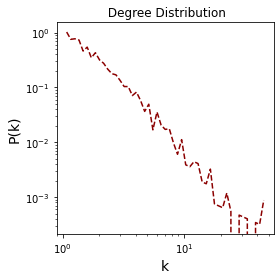

In [23]:
plot_dd(avg_degree,'')

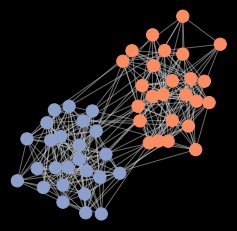

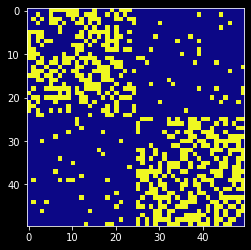

In [77]:
import networkx as nx
import matplotlib.pyplot as plt
import random

# Create a graph object
G = nx.Graph()

# Add 20 nodes to the graph
G.add_nodes_from(range(50))

# Create two assortative communities
comm1 = list(range(25))
comm2 = list(range(25,50))

# Add edges between nodes in the same community
for i in range(len(comm1)):
    for j in range(i+1, len(comm1)):
        if random.random() < 0.4:
            G.add_edge(comm1[i], comm1[j])

for i in range(len(comm2)):
    for j in range(i+1, len(comm2)):
        if random.random() < 0.5:
            G.add_edge(comm2[i], comm2[j])

# Add edges between nodes in different communities
for i in comm1:
    for j in comm2:
        if random.random() < 0.05:
            G.add_edge(i, j)

node_color = []            

for n in G.nodes():
    
    if n in comm1:
        node_color.append('#fc8d62')
    else:
        node_color.append('#8da0cb')

# Draw the graph
pos = nx.spring_layout(G)
plt.figure(figsize=(4,4))
nx.draw_networkx_nodes(G.nodes, pos=pos,node_color=node_color,node_size=150)
nx.draw_networkx_edges(G,pos=pos,edge_color='lightgray',alpha=0.5)
plt.axis('off')
plt.savefig('plots/assortative.png',dpi=500,transparent=True)
plt.show()

plt.style.use("dark_background")
plt.figure(figsize=(4,4))
M = nx.adjacency_matrix(G)
M = M.todense()
plt.imshow(M,cmap='plasma')
plt.savefig('plots/assortative_matrix.png',dpi=500,transparent=True)

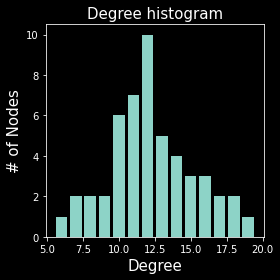

In [78]:
plt.style.use("dark_background")
fig = plt.figure(figsize=(4,4))

degree_sequence = sorted((d for n, d in G.degree()), reverse=True)
ax = fig.add_subplot(111)
ax.bar(*np.unique(degree_sequence, return_counts=True))
ax.set_title("Degree histogram",fontsize=15)
ax.set_xlabel("Degree",fontsize=15)
ax.set_ylabel("# of Nodes",fontsize=15)

fig.tight_layout()

plt.savefig('plots/deg_hist.png',dpi=500,transparent=True)
plt.show()
